# Import needed packages

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import time
import torch
import random
import numpy as np
import pickle
import torch.nn.functional as F
from copy import deepcopy
from multiprocessing import Pool
from tqdm.notebook import tqdm

#from ENV import KYenv
from ENV import DHenv as Env
from DRQN_controller import DRQN_Agent
from DRQN_learner import QLearner
from DRQN_agent import decode_act,get_decay

import matplotlib.pyplot as plt

In [3]:
import time
import torch
import numpy as np
from multiprocessing import Pool

#from ENV import KYenv
from env import Env
from controller_vbc import VDN_MAC
from q_learner_vdn_vbc import QLearner
from run import run
from memory import Memory
from parallel_run_kit import ParallelRun

import matplotlib.pyplot as plt

In [12]:
env = Env(border=torch.Tensor([40, 40]),
          enbs = torch.Tensor([[10, 10, 10],
                               [10, 30, 10],
                               [10, 10, 30],
                               [10, 30, 30]]),
          ues = t_ues,
          noise = 10**(-11.5),
          rw = 0.02
          )

In [4]:
# initialize environments, agents and learner

# initialize environment
#env = KYenv(4, 24, 500)
rw = 0.01
noise_dbm = -85.
env = Env(border=torch.Tensor([40, 40]), 
          enbs = torch.Tensor([[10, 10, 10], 
                               [10, 30, 10], 
                               [10, 10, 30],
                               [10, 30, 30]]), 
          ues = t_ues, 
          noise = 10**(noise_dbm / 10. - 3.),
          rw = rw
          )
'''
env2 = Env(border=torch.Tensor([40, 40]), 
          enbs = torch.Tensor([[10, 10, 10], 
                               [10, 30, 10], 
                               [10, 10, 30],
                               [10, 30, 30]]), 
          ues = t_ues_2, 
          noise = 10**(noise_dbm / 10. - 3.),
          rw = rw
          )
'''

# set saving directory/name
filename = 'AP4UE10L40RW1IR0NOI85SEED_set6_transeed3_nocommu_706_726_lr00001_rms_ep2'
# xx = torch.load('exp_res/AP4UE10L40RW1IR0NOI85SEED_set6_nocommu_706.pth')
# enable cuda in training
cuda_flag = True

# initialize learner
controller = VDN_MAC(n_agents = 4) #n_actions = 6 * 5, input_shape = 11
#controller.save('state_dicts/' + filename + '.pth') # save
# controller.agent.load_state_dict(xx['net_sd']['agent'])
# controller.env_blender.load_state_dict(xx['net_sd']['blender'])
learner = QLearner(controller)
# learner.mixer.load_state_dict(xx['qmixer'])
if cuda_flag:
    learner.cuda()

# initialize test learner
test_controller = VDN_MAC(n_agents = 4) #n_actions = 6 * 5, input_shape = 11, n_size = 256
#test_controller.load('state_dicts/' + filename + '.pth')
# test_controller.agent.load_state_dict(xx['net_sd']['agent'])
# test_controller.env_blender.load_state_dict(xx['net_sd']['blender'])
for par in test_controller.env_blender.parameters():
    par.requires_grad = False
for par in test_controller.agent.parameters():
    par.requires_grad = False

NameError: name 't_ues' is not defined

In [27]:
#epi_length = 0
#epi_length_step = 100

# set batch size
batch_size = 10

# initialze reward and loss saving container
r_history = []
loss_history = []
mess_history = []

In [32]:
# Defining hyperparams
niterations = 300
max_inner_iter = 64
max_test_iter = 500
epi_length = 500
outerstepsize0 = 1
comm_flag = False
batch_size = 64
random_seeds = [0,5,3,6,9,14,16,25,22,29]
k = 0
results_dict = {"loss": None,
               "reward": None}
pbar = tqdm(range(niterations))
best = 0
gamma = 0.98
set_seed(15)
r_history, loss_history = [], []
# Training START!
for k in random_seeds:
    lr = 5e-4
    learner.set_sgd(lr)
    pbar = tqdm(range(niterations))
    env = envs[k]
    r_history, loss_history = [], [] 
    breakpoint()
    for episode in pbar: # train 100 episode at a time, so I can change the hyperparameters every 100 episodes
        if episode % 100 == 0: # the 'if clause' only is True when episode == 0, now.
            runner = ParallelRun(env, controller, epi_length, explore_epsilon=0.3 * (1 - episode/niterations), test_mode = False)
            test_runner = ParallelRun(env, test_controller, epi_length, test_mode = True)
    
        batch = runner.run(1)
        # Transform the training data into a convenient formation.
        breakpoint()
        for key in batch[0].keys():
            batch[0][key] = torch.stack([batch[i][key] for i in range(batch_size)], dim=0)
            if cuda_flag:
                batch[0][key] = batch[0][key].cuda()
        batch = batch[0]
        memory.remember(batch)
        batch = memory.sample(batch_size = batch_size, cuda_flag = cuda_flag)
        breakpoint()
        # train one step. At the same time, check the training loss and the norm of grad.
        if commu_flag:
            loss, grad, diff = learner.train(batch, commu=commu_flag)
        else:
            loss, grad = learner.train(batch, commu=commu_flag)
    # For DQN, it is necessary to update the target network, maybe not important for you
        learner._update_targets()
        # Save the results
        loss_history.append(loss)
#         if commu_flag:
#             mess_history.append(diff)
#             print('loss: ', loss.item(), '   grad: ', grad.item(), '   mess: ', diff.item())
#         else:
#             print('loss: ', loss.item(), '   grad: ', grad.item())
    # save and update the test controller
        controller.save('models/' + filename)
        test_controller.load('models/' + filename)
    # The test result also parallel in 8 samples, The following is the Test of the training model
        test = test_runner.run(1)
    #test = [run(env, test_controller, epi_length, test_mode = True, commu = commu_flag, seed_i = torch.tensor(ii)) for ii in range(6)]
        test = np.mean(test)
    # save test reward    
        r_history.append(test)
    
        pbar.set_description(f"Env:{k}|Iteration:{episode}|loss:{np.mean(loss_history):.2f}|reward:{test:.2f}")
        if test > best and iteration > 10:
            best = test
            print(f"Current best {best:.2f} at iteration {iteration}! Saving.... ")
            test_controller.save(f"./models/dqrn_best_marl_env{k}.pkl")
        if (iteration + 1) % 50 == 0:
            plt.plot(r_history)
            plt.show()

            plt.plot(loss_history)
            plt.show()
            results_dict["loss"] = loss_history
            results_dict["reward"] = r_history
            with open(f"./results/env_{k}_marl_results.pkl", "wb") as file:
                pickle.dump(results_dict, file)
        

0


RuntimeError: mat1 and mat2 shapes cannot be multiplied (4x20 and 9x64)

## 1. Generate random envs

In [5]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

In [20]:
def gen_env(seed, enb_num, ue_num, min_dis):
    
    set_seed(seed)
    enb_pos = torch.zeros(enb_num, 2) - 100
    for i in range(enb_num):
        while True:
            cur_pos = torch.rand(1, 2) * torch.Tensor([40,40])
            dists = torch.sum((enb_pos[i:] - cur_pos)**2, axis = 1)
            if (dists > min_dis).all():
                enb_pos[i] = cur_pos
                break
    ues_pos = torch.rand(ue_num, 2) * torch.Tensor([40, 40])
    enbs = torch.hstack([torch.zeros(enb_num,1) + 10, enb_pos])
    breakpoint()
    env = Env(border=torch.Tensor([40, 40]),
          enbs = enbs,
          ues = ues_pos,
          noise = 10**(-11.5),
          rw = 0.02
          )
    return env

env = gen_env(0, 5, 15, 20)

> <ipython-input-20-cab7f7a5c102>(15)gen_env()
     13     enbs = torch.hstack([torch.zeros(enb_num,1) + 10, enb_pos])
     14     breakpoint()
---> 15     env = Env(border=torch.Tensor([40, 40]),
     16           enbs = enbs,
     17           ues = ues_pos,



ipdb>  c


In [6]:
envs = []


for s in tqdm(range(100)):
    set_seed(s)
    t_aps = torch.rand(k)
    t_ues = torch.rand(10, 2) * torch.Tensor([40, 40])
    env = Env(border=torch.Tensor([40, 40]),
          enbs = torch.Tensor([[10, 10, 10],
                               [10, 30, 10],
                               [10, 10, 30],
                               [10, 30, 30]]),
          ues = t_ues,
          noise = 10**(-11.5),
          rw = 0.02
          )
    envs.append(env)
    

    
with open("./results/envs.pkl", "wb") as file:
    pickle.dump(envs, file)
    
    

  0%|          | 0/100 [00:00<?, ?it/s]

NameError: name 'k' is not defined

In [25]:
# initialize environments, agents and learner


# set saving directory/name
inter_file_name = 'AP4UE10Act5_Reptile_refine.pkl'
# enable cuda in training
cuda_flag = True

# initialize learner
controller = DRQN_Agent(input_shape=64, n_actions=625) #n_actions = 6 * 5, input_shape = 11
controller.save('models/' + inter_file_name)
controller.cuda()
meta_controller = deepcopy(controller)
learner = QLearner(controller,device="cuda",batch_size=32,num_feats=64)
if cuda_flag:
    learner.cuda()

# initialize test learner
test_controller = DRQN_Agent(input_shape=64, n_actions=625) #n_actions = 6 * 5, input_shape = 11
test_controller.load('models/' + inter_file_name)
test_controller.cuda()
test_controller.init_hidden(batch_size=1)


reward = 0

In [4]:
# Generate the original position of UEs

#t_ues = torch.rand(10, 2) * torch.Tensor([40, 40])
#print(t_ues)
test_ues = torch.tensor([[ 2.3219, 35.5963],
        [ 4.9058,  7.3772],
        [34.1434, 24.6237],
        [30.3456, 22.6246],
        [26.9648, 20.9890],
        [19.2420, 32.8353],
        [12.3929, 39.7321],
        [ 5.9339, 29.5289],
        [33.2905, 37.5042],
        [ 9.2728, 15.3940]])

test_env = Env(border=torch.Tensor([40, 40]),
          enbs = torch.Tensor([[10, 10, 10],
                               [10, 30, 10],
                               [10, 10, 30],
                               [10, 30, 30]]),
          ues = test_ues,
          noise = 10**(-11.5),
          rw = 0.02
          )


  0%|          | 0/1000 [00:00<?, ?it/s]

<ipython-input-66-4bc8b68a5afe>:37: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  q = F.softmax(q)
<ipython-input-66-4bc8b68a5afe>:39: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  q_meta = F.softmax(q_meta)


Current best 14.328530311584473! Saving.... 
Current best 14.457195281982422! Saving.... 
Current best 14.53011703491211! Saving.... 
Current best 14.802457809448242! Saving.... 
Current best 14.807644844055176! Saving.... 
Current best 16.013803482055664! Saving.... 


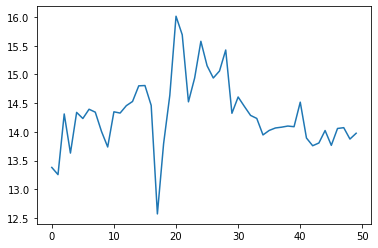

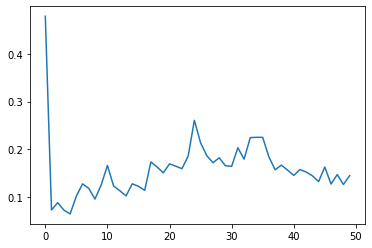

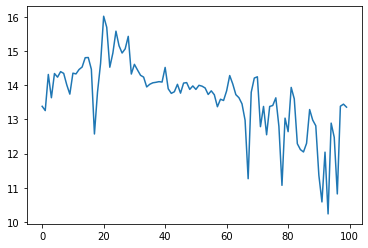

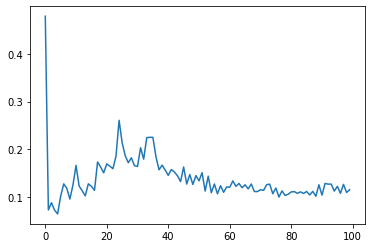

Current best 16.221107482910156! Saving.... 
Current best 16.301599502563477! Saving.... 


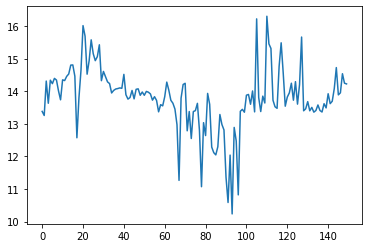

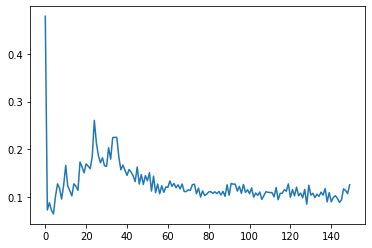

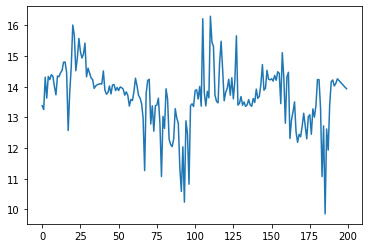

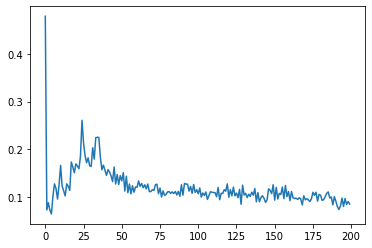

In [ ]:
# Defining hyperparams
niterations = 1000
max_inner_iter = 300
max_test_iter = 500
outerstepsize0 = 1
random_seeds = [0,5,3,6,9,14,16,25,22,29]
pbar = tqdm(range(niterations))
best = 0
gamma = 0.98
set_seed(15)
r_history, loss_history = [], []

for iteration in pbar:
    weights_before = deepcopy(controller.agent.state_dict())
    meta_controller.agent.load_state_dict({name : 
        weights_before[name] for name in weights_before})
    seed_num = random.choice(random_seeds)
    env = envs[seed_num]
    env.reset()
    inner_step = 0
    lr = 5e-4
    learner.set_sgd(lr)
#     learner.memory.memory = []
    losses = []
    for inner_iter in range(max_inner_iter):
        inner_step += 1
        obs = []
        for j in range(env.n_enbs):
            obs.append(env.get_agent_obs(j))
        obs = torch.stack(obs, dim=0)
        obs = torch.flatten(obs)
        cur_obs = obs.reshape(1,64).cuda()
#         meta_obs = obs.detach().copy()
        controller.init_hidden(1)
#         breakpoint()
        action,q = controller.get_action(cur_obs, 0.3*(1-inner_iter/max_inner_iter))
        q = F.softmax(q)
        _,q_meta = meta_controller.get_action(cur_obs, 0)
        q_meta = F.softmax(q_meta)
        kl_diff = F.kl_div(q, q_meta.cuda(),reduction="batchmean")
#         breakpoint()
        act = decode_act(action,4,5)
        s_t1,r = env.step(act)
        r = r - 0.3* kl_diff
        s_t1 = torch.flatten(s_t1)
        controller.init_hidden(512)
        loss, grad = learner.train(obs.numpy(), action,
                                   r.item(), s_t1.numpy(), inner_step)
        if loss is not None:
            losses.append(loss.item())
        if (inner_iter + 1) % 100 == 0:
            lr = lr/2
            learner.set_sgd(lr)
    weights_after = controller.agent.state_dict()
    outerstepsize = outerstepsize0 * (1 - iteration / niterations) # linear schedule
    controller.agent.load_state_dict({name : 
        weights_before[name] + (weights_after[name] - weights_before[name]) * outerstepsize 
        for name in weights_before})
    learner._update_targets()
    # Save the results
    if losses != []:
        loss_history.append(np.mean(losses))
    # save and update the test controller
    controller.save('models/' + inter_file_name)
    test_controller.load('models/' + inter_file_name)
    test_env.reset()
    reward = 0
    for test_iter in range(max_test_iter):
        obs = []
        for j in range(test_env.n_enbs):
            obs.append(test_env.get_agent_obs(j))
        obs = torch.stack(obs, dim=0)
        obs = torch.flatten(obs)
        action,_ = test_controller.get_action(
            torch.reshape(obs,(1,64)).cuda(), 0.0)
        act = decode_act(action,4, 5)
        s_t1,r = test_env.step(act)
        reward += (1 - gamma) * (r - reward)
    r_history.append(reward.item())
    pbar.set_description(f"Iteration:{iteration}|loss:{np.mean(losses)}|reward:{reward.item()}")
    if reward.item() > best and iteration > 10:
        best = reward.item()
        print(f"Current best {best}! Saving.... ")
        test_controller.save("./models/drqn_best_reptile_kl.pkl")
    if (iteration + 1) % 50 == 0:
        plt.plot(r_history)
        plt.show()

        plt.plot(loss_history)
        plt.show()

In [22]:
print(best)

18.57648468017578


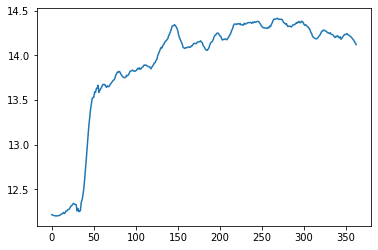

In [65]:
from scipy.signal import savgol_filter
plt.plot(savgol_filter(r_history,21,2))
plt.show()

In [64]:
test_controller.load("./models/drqn_best_reptile_kl.pkl")
controller.load("./models/drqn_best_reptile_kl.pkl")

random_seeds = [0,5,3,6,9,14,16,25,22,29]
gamma = 0.98
max_test_iter = 500
max_tunning_iter = 50




for s in random_seeds:
    
    env = envs[s]
    env.reset()
    
    
    learner.memory.memory = []
    reward = 0
    inner_step = 160
    losses = []
    learner.set_sgd(1e-4)
    
    for inner_iter in range(max_tunning_iter):
        inner_step += 1
        obs = []
        for j in range(env.n_enbs):
            obs.append(env.get_agent_obs(j))
        obs = torch.stack(obs, dim=0)
        obs = torch.flatten(obs)
        controller.init_hidden(1)
        action,q = controller.get_action(torch.reshape(obs,(1,64)).cuda(), 0.3*(1-inner_iter/max_tunning_iter))
        act = decode_act(action,4,5)
        s_t1,r = env.step(act)
        s_t1 = torch.flatten(s_t1)
        controller.init_hidden(512)
        loss, grad = learner.train(obs.numpy(), action,
                                   r.item(), s_t1.numpy(), inner_step)
        if loss is not None:
            losses.append(loss.item())
            
    learner._update_targets()
    
    controller.save('models/' + inter_file_name)
    test_controller.load('models/' + inter_file_name)
    
    for test_iter in range(max_test_iter):
        obs = []
        for j in range(env.n_enbs):
            obs.append(env.get_agent_obs(j))
        obs = torch.stack(obs, dim=0)
        obs = torch.flatten(obs)
        action, q = test_controller.get_action(
            torch.reshape(obs,(1,64)).cuda(), 0.0)
        act = decode_act(action,4, 5)
        s_t1,r = env.step(act)
        reward += (1 - gamma) * (r - reward)
        
    print(f"Reward on env {s} with {max_tunning_iter} steps is: {reward.item()}")
    
    



ValueError: Sample larger than population or is negative

In [3]:
# initialize environments, agents and learner

# initialize environment
#env = KYenv(4, 24, 500)
env = Env(border=torch.Tensor([40, 40]),
          enbs = torch.Tensor([[10, 10, 10],
                               [10, 30, 10],
                               [10, 10, 30],
                               [10, 30, 30]]),
          ues = t_ues,
          noise = 10**(-11.5),
          # rw = 0.01
          )

# set saving directory/name
filename = 'AP4UE10Act5_DRQN.pkl'
# enable cuda in training
cuda_flag = True

# initialize learner
controller = DRQN_Agent(input_shape=64, n_actions=625) #n_actions = 6 * 5, input_shape = 11
# controller.save('models/' + filename)
learner = QLearner(controller,device="cuda",batch_size=32,num_feats=64)
if cuda_flag:
    learner.cuda()

# initialize test learner
test_controller = DRQN_Agent(input_shape=64, n_actions=625) #n_actions = 6 * 5, input_shape = 11
test_controller.load('models/' + filename)
test_controller.cuda()
test_controller.init_hidden(batch_size=1)


reward = 0


In [4]:
#epi_length = 0
#epi_length_step = 100

# set batch size
batch_size = 8
epi_step = 0
total_step = 0
best = 0


# initialze reward and loss saving container
r_history = []
loss_history = []

In [10]:
max_epi_iter = 100
max_MC_iter = 64
learner.set_sgd(1e-4)
# controller.load("././models/drqn_best_5.pkl")



for epi_iter in range(max_epi_iter):
    env.reset()
    losses = []
    rewards = []
    epi_step += 1

    for MC_iter in range(max_MC_iter):
        # env.render()
        total_step += 1
        obs = []
        for j in range(env.n_enbs):
            obs.append(env.get_agent_obs(j))
        obs = torch.stack(obs, dim=0)
        obs = torch.flatten(obs)
        controller.init_hidden(1)
        action = controller.get_action(torch.reshape(obs,(1,64)).cuda(),
                                               0.3)
        act = decode_act(action,4,5)
        s_t1,r = env.step(act)
        s_t1 = torch.flatten(s_t1)
        controller.init_hidden(512)
        loss, grad = learner.train(obs.numpy(), action,
                                   r.item(), s_t1.numpy(), total_step)
        if loss is not None:
            losses.append(loss.item())


    learner._update_targets()

    # Save the results
    if losses != []:
        loss_history.append(np.mean(losses))

    # save and update the test controller
    controller.save('models/' + filename)
    test_controller.load('models/' + filename)



    for test_round in range(max_MC_iter):

        obs = []
        for j in range(env.n_enbs):
            obs.append(env.get_agent_obs(j))
        obs = torch.stack(obs, dim=0)
        obs = torch.flatten(obs)
        action = test_controller.get_action(
            torch.reshape(obs,(1,64)).cuda(), 0.0)
        act = decode_act(action,4, 5)
        s_t1,r = env.step(act)
        rewards.append(r)



    # save test reward
    r_history.append(np.mean(rewards))



    print('Episode', epi_iter, 'reward', np.mean(rewards), "\n loss",
          np.mean(losses),  "grad_norm", grad)
    if np.mean(rewards) > best and epi_step > 10:
        best = np.mean(rewards)
        print(f"Current best {best}! Saving.... ")
        test_controller.save("./models/drqn_best_5.pkl")


    # For DQN, it is necessary to update the target network, maybe not important for you

    if (epi_iter + 1) % 50 == 0:
        plt.plot(r_history)
        plt.show()

        plt.plot(loss_history)
        plt.show()


Episode 0 reward 19.293806 
 loss 0.10866947152784892 grad_norm None
Episode 1 reward 20.529655 
 loss 0.09176110724608104 grad_norm None
Episode 2 reward 21.852776 
 loss 0.10897738167217799 grad_norm tensor(2.7835, device='cuda:0')
Current best 21.85277557373047! Saving.... 
Episode 3 reward 20.611004 
 loss 0.10362709624071915 grad_norm None
Episode 4 reward 21.300648 
 loss 0.09209070044259231 grad_norm None
Episode 5 reward 21.560446 
 loss 0.07166254680071558 grad_norm None


KeyboardInterrupt: 

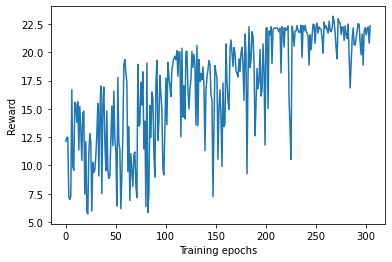

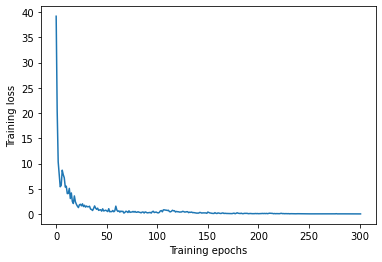

In [35]:

plt.plot(r_history)
plt.xlabel("Training epochs")
plt.ylabel("Reward")
plt.savefig("training_reward_5_rw.png")
plt.show()

plt.plot(loss_history)
plt.xlabel("Training epochs")
plt.ylabel("Training loss")
plt.savefig("training_loss_5_rw.png")
plt.show()

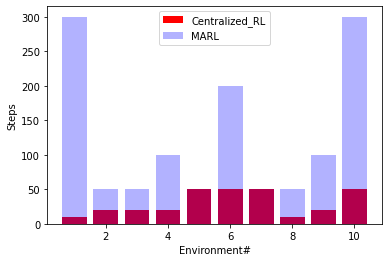

In [6]:
centralized_dist = [10,20,20,20,50,50,50,10,20,50]
marl_dist = [300,50,50,100,50,200,50,50,100,300]
env_num = [1,2,3,4,5,6,7,8,9,10]

plt.figure()

plt.bar(env_num,centralized_dist,alpha=1,label="Centralized_RL",color="r")
plt.bar(env_num,marl_dist,alpha=0.3,label="MARL",color="b")
plt.xlabel("Environment#")
plt.ylabel("Steps")
plt.legend()
plt.show()

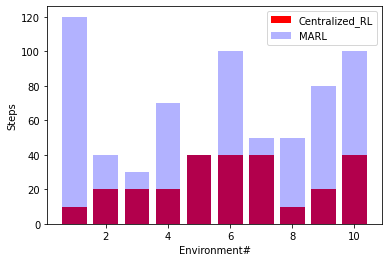

In [7]:
centralized_dist = [10,20,20,20,40,40,40,10,20,40]
marl_dist = [120,40,30,70,40,100,50,50,80,100]
env_num = [1,2,3,4,5,6,7,8,9,10]

plt.figure()

plt.bar(env_num,centralized_dist,alpha=1,label="Centralized_RL",color="r")
plt.bar(env_num,marl_dist,alpha=0.3,label="MARL",color="b")
plt.xlabel("Environment#")
plt.ylabel("Steps")
plt.legend()
plt.show()

In [26]:
inds = [
    [1,3,4,7,9],
    [1,2,3,4,9],
    [0,5,6,7,9],
    [2,3,4,5,8]
        ]


[1,3,4,5,9]

[]


In [18]:
def draw(env, size_on=True, serve_on=True):
        # draw UEs position
    plt.figure(dpi=100, figsize=[5, 5])
    plt.xlim(0, env.border[0])
    plt.ylim(0, env.border[1])
    t_ues = env.ues_pos
    if size_on:
        t_size = env.MA_rate.numpy()
    else:
        t_size = 5

#     print(t_size.shape, t_ues.shape)

    plt.scatter(t_ues[:, 0], t_ues[:, 1], s = np.transpose(t_size * 100))

    if serve_on:
       plt.scatter(env.enbs_pos[:,0],env.enbs_pos[:,1],marker="x",s = 200)
    plt.show()

In [11]:
# random test
gamma = 0.98
test_controller.load("./models/drqn_best_5.pkl")


rl = []
for _ in range(20):
    obs = env.reset()
    r = 0.0
    dup = 0
    for t in range(500):
        obs = []
        ind = set()
        inds = []
        env.get_global_obs()
        for j in range(env.n_enbs):
            obs.append(env.get_agent_obs(j))
            inds.append(obs[j][:,0])
        obs = torch.stack(obs, dim=0)

        obs = torch.flatten(obs)
        action = test_controller.get_action(torch.reshape(obs,(1,64)).cuda(),0.0)
        act = decode_act(action,4,5)
        for k in range(4):
            if act[k] != 4:
                ind.add(inds[k][act[k]])
            else:
                ind.add(k + 100)
        if len(ind) < 4:
            dup += 1
        s_t1,reward = env.step(act)
        r += (1 - gamma) * (reward - r)
        if (t + 1) % 100 == 0:
            draw(env)
    rl.append(r)
    print(dup / 500)


print(np.mean(rl), np.std(rl))



KeyboardInterrupt: 

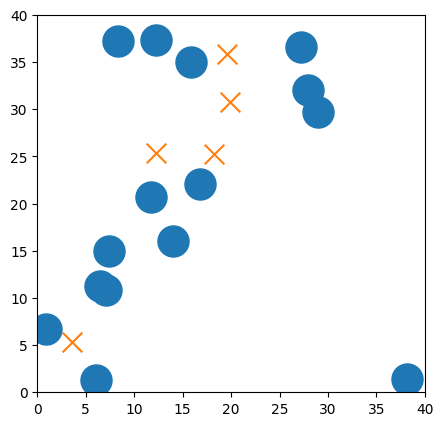

In [21]:
draw(env,False)